In [1]:
import wbdata 
import pandas as pd
import datetime 
import json
from pandas.io.json import json_normalize
import statsmodels
import numpy as np
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima.utils import ndiffs
from pmdarima.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
###############################
## Part 1: Create ESG index  ##
###############################

In [2]:
# explore data sources and zoom in the most relevant group: 75  Environment, Social and Governance (ESG) Data
wbdata.get_source() 
id = wbdata.get_indicator(source=75)
#id

In [3]:
# to zoom in a particular data item, say the 4th item

id_dict = dict(id[4])
id_dict

{'id': 'EG.CFT.ACCS.ZS',
 'name': 'Access to clean fuels and technologies for cooking (% of population)',
 'unit': '',
 'source': {'id': '75',
  'value': 'Environment, Social and Governance (ESG) Data'},
 'sourceNote': 'Access to clean fuels and technologies for cooking is the proportion of total population primarily using clean cooking fuels and technologies for cooking. Under WHO guidelines, kerosene is excluded from clean cooking fuels.',
 'sourceOrganization': 'World Bank, Sustainable Energy for All (SE4ALL) database from WHO Global Household Energy database.',
 'topics': [{'id': '6', 'value': 'Environment '}]}

In [4]:
# explore data items and related topics, and collect all topics 
alltopics = []
names = []
for i in range(len(id)):
    id_dict = dict(id[i])
    print(i+1, id_dict['name'])
    topicls = id_dict['topics']
    topic = [dd['value'] for dd in topicls]
    print(topic)
    alltopics.extend(topic)
    names.append(id_dict['name'])
    print()

1 Agricultural land (% of land area)
['Agriculture & Rural Development  ', 'Climate Change', 'Environment ']

2 Forest area (% of land area)
['Agriculture & Rural Development  ', 'Climate Change', 'Environment ']

3 Food production index (2014-2016 = 100)
['Agriculture & Rural Development  ']

4 Control of Corruption: Estimate
[]

5 Access to clean fuels and technologies for cooking (% of population)
['Environment ']

6 Energy intensity level of primary energy (MJ/$2011 PPP GDP)
['Energy & Mining ', 'Environment ']

7 Access to electricity (% of population)
['Energy & Mining ', 'Climate Change', 'Environment ']

8 Electricity production from coal sources (% of total)
['Energy & Mining ', 'Climate Change', 'Infrastructure ']

9 Renewable electricity output (% of total electricity output)
['Energy & Mining ', 'Climate Change', 'Environment ']

10 Renewable energy consumption (% of total final energy consumption)
['Energy & Mining ', 'Climate Change', 'Environment ']

11 Energy imports, n

KeyError: 'value'

In [5]:
# list all topics in a set for grouping
topicset = set(alltopics)
print(topicset)


{'Agriculture & Rural Development  ', 'Science & Technology ', 'Private Sector', 'Public Sector ', 'Social Protection & Labor', 'Energy & Mining ', 'Health ', 'Education ', 'Trade', 'Urban Development ', 'Gender', 'Poverty ', 'Infrastructure ', 'Economy & Growth', 'Social Development ', 'Climate Change', 'Financial Sector ', 'Environment ', 'Aid Effectiveness '}


In [6]:
# These topics will be used in contructing the main factors in the index under each of the three ESG pillars,
#  the data items will be grouped under the respective factors
# For example, under the "Environemntal" pillar, for sub-factors "Energy Security" and "Renewable Energy", 
#  the relevant data items are:

env_topics = {'Natural Resources': {'Energy Security': ['Access to electricity (% of population)', 
                                                       'Electricity production from coal sources (% of total)',
                                                       'Fossil fuel energy consumption (% of total)',
                                                        'Energy imports, net (% of energy use)'],
                                   'Renewable Energy': ['Renewable electricity output (% of total electricity output)',
                                                        'Renewable energy consumption (% of total final energy consumption)',
                                                        'Access to clean fuels and technologies for cooking (% of population)']},
                'Climate Change': {'key': 'value'}}

In [ ]:
####################################################
## Part 2: Forecaset sovereign bond yield spread  ##
####################################################

# using an ARIMA model with exogenous covariates

In [7]:
spread = pd.read_csv('2021_ESG_datascientist_casestudy_v2_data.csv')
spread.head(3)

,Date,ARG,BHR,BGD,BRB,BRA,CHL,CHN,COL,CRI,...,ZAF,KOR,TWN,TZA,THA,TTO,TUR,UKR,ARE,ZWE
0,1/29/10,464.351,392.941,NaN,712.853,304.662,224.502,667.424,373.192,NaN,...,459.082,254.194,400.960,NaN,283.215,NaN,517.126,1376.331,408.946,NaN
1,2/26/10,460.941,427.910,NaN,759.959,288.340,249.703,744.089,356.209,NaN,...,514.118,256.855,422.153,NaN,288.972,NaN,526.159,1411.650,409.554,NaN
2,3/31/10,383.004,394.637,NaN,618.887,240.890,232.358,663.063,312.686,NaN,...,441.662,220.201,365.876,NaN,248.962,NaN,503.233,787.873,319.135,NaN


In [8]:
# countries in yield spread data are identified with three-letter codes, while WB database takes country name in query
#  - create a dictionary
emerg_code = list(spread.columns)[1:]
data_date0 = datetime.datetime(2020, 1, 1) 
dat_j = wbdata.get_data('EG.FEC.RNEW.ZS', country='all',  convert_date=True, data_date=data_date0)
country_name_code = pd.DataFrame.from_dict(pd.io.json.json_normalize(dat_j), orient='columns')
country_name_code.rename(columns={'country.value': 'countryname'}, inplace=True)
#country_name_code.head()
code_name_dict = dict(zip(list(country_name_code.countryname), list(country_name_code.countryiso3code)))
#code_name_dict['Argentina']

<ipython-input-8-0f20df163e98>:6: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  country_name_code = pd.DataFrame.from_dict(pd.io.json.json_normalize(dat_j), orient='columns')


In [9]:
# get list of emerging economy country names
emergtmp = country_name_code[country_name_code['countryiso3code'].isin(emerg_code)]
emerg_country = list(emergtmp['countryname'])
#emerg_country

In [10]:
# select a list of predictors - from ESG data and macroeconomic factors
macro_id = { 'FP.CPI.TOTL.ZG':'cpi', 
            'NY.GDP.MKTP.KD.ZG':'gdp_growth', 'GE.EST':'gov_eff'} 
            #'GC.BAL.CASH.CD':'fiscal_bal',  'JI.UEM.1564.ZS':'unemp'#,  'DT.DOD.DSTC.IR.ZS':'short_debt_reserve',  
            #'FR.INR.RINR':'real_int', 'GC.DOD.TOTL.GD.ZS':'gov_debt',    'BN.CAB.XOKA.GD.ZS':'cur_acct_bal',

# since some variables have many missing values, only keeping the ones available for most countries       

In [11]:
data_date=datetime.datetime(2009, 1, 1), datetime.datetime(2020, 1, 1)
macrodf = wbdata.get_dataframe(macro_id, country=emerg_code, convert_date=True, data_date=data_date)
macrodf.reset_index(inplace=True)
macrodf.set_index('date', inplace=True)
macrodf['countrycode'] = macrodf['country'].map(code_name_dict)
#macrodf.describe()
#macrodf.head(3)

In [12]:
## build country-specific dataframe for analysis
def get_countrydata(macrodf, spread, sel_country):
    country_macro = macrodf[macrodf['countrycode']==sel_country].dropna(axis=1, how='all')
    # interpolate variables to monthly frequency
    country_macro_intp = country_macro.resample('M').ffill(limit=1).interpolate(method='linear').reset_index()
    country_macro_intp = country_macro_intp.dropna(axis=1, how='all')
    # offset by one month forward, so lagged covariate values are used in the model
    country_macro_intp.date = country_macro_intp.date +  pd.DateOffset(months=1)
    # turn date to month to match yield spread data
    country_macro_intp['month'] = country_macro_intp['date'].dt.to_period('M')
    country_macro_intp = country_macro_intp.drop(['country','countrycode'], axis=1)
    
    # yield spread of one country
    spread_series = spread[['Date',sel_country]]
    spread_series = spread_series.rename(columns={sel_country:'value'})
    spread_series['Date']= pd.to_datetime(spread_series['Date'])
    spread_series['month'] = spread_series['Date'].dt.to_period('M')
    spread_series.dropna(inplace=True)
    
    # merge two datasets
    df = pd.merge(spread_series, country_macro_intp, how='left', on='month')
    df.set_index('Date', inplace=True)
    df.dropna(inplace=True)
    return df

In [13]:
# select country and find country name (for plotting)
sel_country = 'ARG'
sel_countryname = [k for k,v in code_name_dict.items() if v == sel_country][0]

In [14]:
df = get_countrydata(macrodf = macrodf, spread = spread, sel_country = sel_country)
df.head(3)

,value,month,date,gdp_growth,gov_eff
Date,,,,,
2010-01-29,464.351,2010-01,2010-01-31,8.788405,-0.175813
2010-02-26,460.941,2010-02,2010-02-28,10.125398,-0.162862
2010-03-31,383.004,2010-03,2010-03-28,9.781944,-0.159298


In [16]:
# split into training and test sets
train, test = train_test_split(df, train_size=int(len(df)*.75))

In [17]:
# ARIMA model with exogenous covariates

covariates = list(df)[3:] # last colums are covariates

sxmodel = pm.auto_arima(train[['value']], exogenous=train[covariates],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=0,
                           start_P=0, seasonal=False,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1027.051, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1025.058, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1026.874, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1026.847, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1023.060, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.571 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   91
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -508.530
Date:                Tue, 21 Dec 2021   AIC                           1023.060
Time:                        15:29:35   BIC                           1030.559
Sample:                    01-29-2010   HQIC                          1026.084
                         - 07-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
gdp_growth   -16.8230     19.316     -0.871      0.384     -54.681      21.035
gov_eff     -515.8447    773.631     -0.667      0.505   -2032.134    1000.445
sigma2      4735.3448    535.216      8.848      0.000    3686.340    5784.350
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                15.18
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                            -0.27
Prob(H) (two-sided):                  0.66   Kurtosis:                         4.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

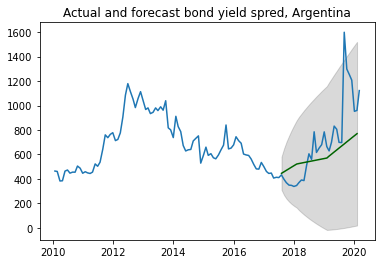

In [18]:
# forecast
n_periods = len(test)

fitted, confint = sxmodel.predict(n_periods=n_periods, 
                                  exogenous=test[covariates], 
                                  return_conf_int=True)

index_of_fc = pd.date_range(test.month[0].to_timestamp(), periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)
actual_series = pd.Series(test.value, index=index_of_fc)

# plot
plt.plot(df['value'])
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Actual and forecast bond yield spred, "+sel_countryname)
plt.show()

In [19]:
# evalauate model performance mean absolute percentage error (MAPE)
np.mean(np.abs(fitted - test.value)/np.abs(test.value)) 

0.26108449637691966